### LSTM (Stock Price Features only)

In [1]:
#Importing libraries
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler, RobustScaler
import seaborn as sns

In [2]:
#Read the csv file
df = pd.read_csv('BP_yahoofinance.csv')
print(df.head()) #7 columns, including the Date. 

         Date       Open       High        Low      Close  Adj Close    Volume
0  2022-01-03  26.690001  27.480000  26.650000  27.370001  24.747339   9785600
1  2022-01-04  28.129999  28.700001  28.110001  28.549999  25.814268  15444300
2  2022-01-05  28.930000  29.070000  28.360001  28.370001  25.651520  13507900
3  2022-01-06  29.020000  29.120001  28.590000  28.809999  26.049353  13366900
4  2022-01-07  29.270000  29.700001  29.080000  29.670000  26.826948  16171800


In [3]:
#Converting dates to 'datetime'
train_dates = pd.to_datetime(df['Date'])
print(train_dates.tail(5)) #Check last few dates. 

557   2024-03-22
558   2024-03-25
559   2024-03-26
560   2024-03-27
561   2024-03-28
Name: Date, dtype: datetime64[ns]


In [4]:
train_dates

0     2022-01-03
1     2022-01-04
2     2022-01-05
3     2022-01-06
4     2022-01-07
         ...    
557   2024-03-22
558   2024-03-25
559   2024-03-26
560   2024-03-27
561   2024-03-28
Name: Date, Length: 562, dtype: datetime64[ns]

In [5]:
#Variables for training
cols = list(df)[1:7]
#Date column is not used in training. 
print(cols)

['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']


In [6]:
#New dataframe with only training data 
df_for_training = df[cols] 
print(df_for_training.head())

        Open       High        Low      Close  Adj Close    Volume
0  26.690001  27.480000  26.650000  27.370001  24.747339   9785600
1  28.129999  28.700001  28.110001  28.549999  25.814268  15444300
2  28.930000  29.070000  28.360001  28.370001  25.651520  13507900
3  29.020000  29.120001  28.590000  28.809999  26.049353  13366900
4  29.270000  29.700001  29.080000  29.670000  26.826948  16171800


<Axes: >

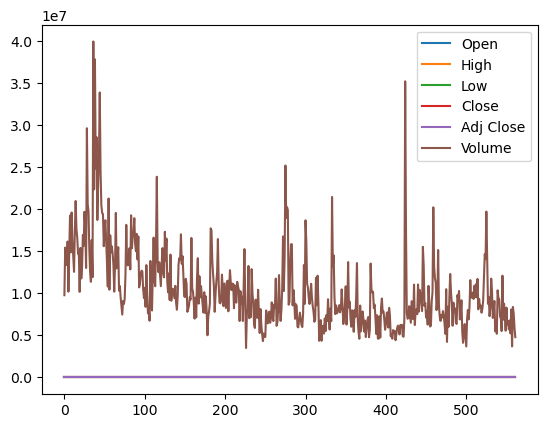

In [7]:
df_for_plot=df_for_training.tail(5000)
df_for_plot.plot.line()

In [8]:
# normalize the dataset
scaler = RobustScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)

<Axes: >

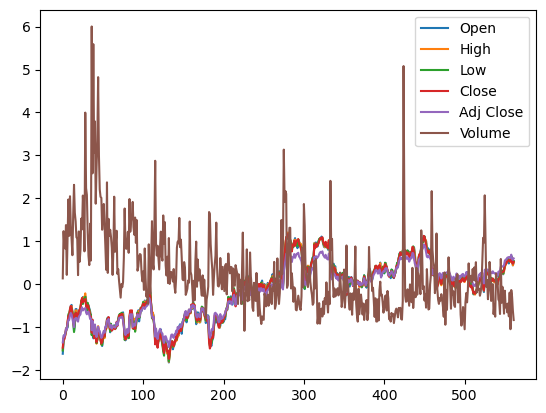

In [9]:
# Convert the scaled array back to a DataFrame
df_for_training_scaled_plot = pd.DataFrame(df_for_training_scaled, columns=df_for_training.columns)
# Select the last 5000 rows
df_for_plot2 = df_for_training_scaled_plot.tail(5000)
# Plot the DataFrame
df_for_plot2.plot.line()

In [10]:
#As required for LSTM networks, we require to reshape an input data into n_samples x timesteps x n_features. 
#In this example, the n_features is 5. We will make timesteps = 14 (past days data used for training). 

#Empty lists to be populated using formatted training data
trainX = []
trainY = []

n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 14  # Number of past days we want to use to predict the future.

#Reformat input data into a shape: (n_samples x timesteps x n_features)
for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])

trainX, trainY = np.array(trainX), np.array(trainY)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

trainX shape == (548, 14, 6).
trainY shape == (548, 1).


#### 548 rows / 14 days (n_past) / 5 variables 

In [11]:
# define the Autoencoder model

model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary()


C:\Users\leona\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 14, 64)         │        18,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,625 (119.63 KB)

 Trainable params: 30,625 (119.63 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# fit the model
history = model.fit(trainX, trainY, epochs=5, batch_size=16, validation_split=0.1, verbose=1)

Epoch 1/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - loss: 0.2741 - val_loss: 0.0252
Epoch 2/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0942 - val_loss: 0.0243
Epoch 3/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0730 - val_loss: 0.0231
Epoch 4/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0720 - val_loss: 0.0196
Epoch 5/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0672 - val_loss: 0.0165


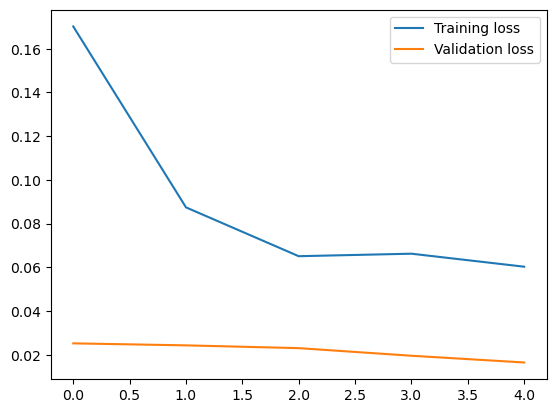

In [13]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [14]:
#Predicting...
#Libraries that will help us extract only business days in the US.
#Otherwise our dates would be wrong when we look back (or forward).  
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())
#Remember that we can only predict one day in future as our model needs 5 variables
#as inputs for prediction. We only have all 5 variables until the last day in our dataset.
n_past = 16
n_days_for_prediction=15  #let us predict past 15 days

predict_period_dates = pd.date_range(list(train_dates)[-n_past], periods=n_days_for_prediction, freq=us_bd).tolist()
print(predict_period_dates)

#Make prediction
prediction = model.predict(trainX[-n_days_for_prediction:]) #shape = (n, 1) where n is the n_days_for_prediction

#Perform inverse transformation to rescale back to original range
#Since we used 5 variables for transform, the inverse expects same dimensions
#Therefore, let us copy our values 5 times and discard them after inverse transform
prediction_copies = np.repeat(prediction, df_for_training.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copies)[:,0]

[Timestamp('2024-03-07 00:00:00'), Timestamp('2024-03-08 00:00:00'), Timestamp('2024-03-11 00:00:00'), Timestamp('2024-03-12 00:00:00'), Timestamp('2024-03-13 00:00:00'), Timestamp('2024-03-14 00:00:00'), Timestamp('2024-03-15 00:00:00'), Timestamp('2024-03-18 00:00:00'), Timestamp('2024-03-19 00:00:00'), Timestamp('2024-03-20 00:00:00'), Timestamp('2024-03-21 00:00:00'), Timestamp('2024-03-22 00:00:00'), Timestamp('2024-03-25 00:00:00'), Timestamp('2024-03-26 00:00:00'), Timestamp('2024-03-27 00:00:00')]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step


In [15]:
# Convert timestamp to date
forecast_dates = []
for time_i in predict_period_dates:
    forecast_dates.append(time_i.date())

In [16]:
df_forecast = pd.DataFrame({'Date':np.array(forecast_dates), 'Open':y_pred_future})
df_forecast['Date']=pd.to_datetime(df_forecast['Date'])

In [17]:
original = df[['Date', 'Open']]
original['Date']=pd.to_datetime(original['Date'])
original = original.loc[original['Date'] >= '2020-5-1']

C:\Users\leona\AppData\Local\Temp\ipykernel_3020\2126096244.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original['Date']=pd.to_datetime(original['Date'])


In [18]:
# sns.lineplot(original['Date'], original['Open'])
# sns.lineplot(df_forecast['Date'], df_forecast['Open'])

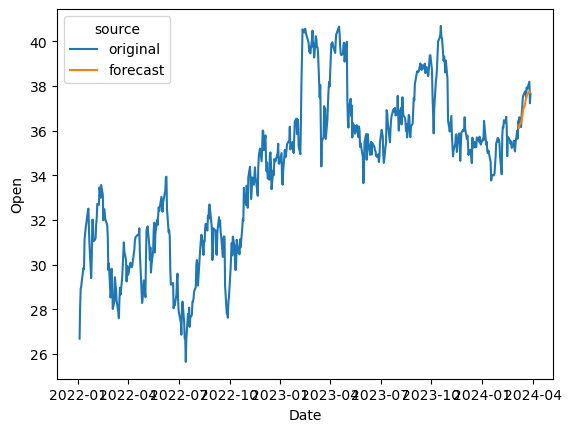

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

# Convert 'Date' column to datetime format in both 'original' and 'df_forecast'
original['Date'] = pd.to_datetime(original['Date'])
df_forecast['Date'] = pd.to_datetime(df_forecast['Date'])

# Combine original and forecasted data into a single DataFrame with a new 'source' column
original['source'] = 'original'
df_forecast['source'] = 'forecast'
combined_data = pd.concat([original, df_forecast])

# Plotting the combined data
sns.lineplot(data=combined_data, x='Date', y='Open', hue='source')
plt.show()

In [20]:
# fit the model
history = model.fit(trainX, trainY, epochs=5, batch_size=16, validation_split=0.1, verbose=1)

# Print final training and validation loss
print("Final training loss:", history.history['loss'][-1])
print("Final validation loss:", history.history['val_loss'][-1])

Epoch 1/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0486 - val_loss: 0.0206
Epoch 2/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0524 - val_loss: 0.0154
Epoch 3/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0387 - val_loss: 0.0163
Epoch 4/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0470 - val_loss: 0.0151
Epoch 5/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0470 - val_loss: 0.0134
Final training loss: 0.04270196706056595
Final validation loss: 0.013388500548899174


In [21]:
import math
from sklearn.metrics import mean_squared_error

# Predicting...
prediction = model.predict(trainX[-n_days_for_prediction:])

# Perform inverse transformation to rescale back to original range
prediction_copies = np.repeat(prediction, df_for_training.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copies)[:, 0]

# Obtain true values for the predicted period
true_values = df_for_training.values[-n_days_for_prediction:]

# Calculate RMSE
rmse = math.sqrt(mean_squared_error(true_values[:, 0], y_pred_future)) 
print("Root Mean Squared Error (RMSE):", rmse)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Root Mean Squared Error (RMSE): 0.383506028847448


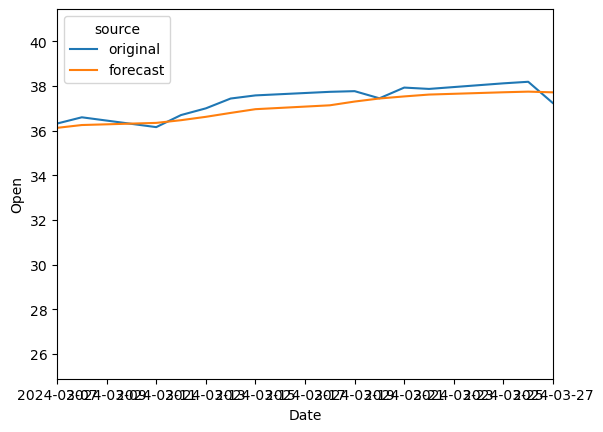

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

# Convert 'Date' column to datetime format in both 'original' and 'df_forecast'
original['Date'] = pd.to_datetime(original['Date'])
df_forecast['Date'] = pd.to_datetime(df_forecast['Date'])

# Combine original and forecasted data into a single DataFrame with a new 'source' column
original['source'] = 'original'
df_forecast['source'] = 'forecast'
combined_data = pd.concat([original, df_forecast])

# Plotting the combined data
sns.lineplot(data=combined_data, x='Date', y='Open', hue='source')
plt.xlim(df_forecast['Date'].min(), df_forecast['Date'].max())  # Limit x-axis to forecast dates
plt.show()